<a href="https://colab.research.google.com/github/eliza-giane/super-resolution-dl-project/blob/main/ACDC_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**This is the Automated Cardiac Disease Challenge (ACDC) Project for Deep Learning at AIT by Eliza Giane, Shirui Li, and Lydia Yang.**


This project was prompted by the challenge (found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html)). The data consists of real anonymized and regulated clinical exams from the University Hospital of Dijon, and is described as follows on the challenge's website:

---
"Our dataset covers several well-defined pathologies with enough cases to (1) properly train machine learning methods and (2) clearly assess the variations of the main physiological parameters obtained from cine-MRI (in particular diastolic volume and ejection fraction)."

"The dataset is composed of 150 exams (all from different patients) divided into 5 evenly distributed subgroups (4 pathological plus 1 healthy subject groups)...Furthermore, each patient comes with the following additional information : weight, height, as well as the diastolic and systolic phase instants."

---
 The dataset to be downloaded is found [here](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc).

  <!-- and the provided code for handling .nii files is found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/code/metrics_acdc.py). -->

\\
**Any use of the ACDC database requires the following citation:**

O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.
"Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and Diagnosis: Is the Problem Solved ?" in IEEE Transactions on Medical Imaging, vol. 37, no. 11, pp. 2514-2525, Nov. 2018, doi: 10.1109/TMI.2018.2837502

Running the code:

Please download and move the dataset to your Google Drive under MyDrive and rename the folder "ACDC-Challenge" to run the code as is. Otherwise, change the variable dataDir in the below code cell to your local folder.

In [41]:
import nibabel as nib
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import cv2
from configparser import ConfigParser
from skimage import io
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

from google.colab import drive
drive.mount('/content/drive')
dataDir = '/content/drive/MyDrive/ACDC-Challenge/database/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
def patientNames(trainingOrTesting):
  '''
  Returns a list of patient file names
  trainingOrTesting = "training" or "testing"
  '''
  if trainingOrTesting == 'training':
    L = []
    for i in range(1, 101):
        if i < 10:
            patient = "patient" + "00" + str(i)
        elif 10 <= i <= 99:
            patient = "patient" + "0" + str(i)
        else:
            patient = "patient" + str(i)
        L.append(patient)
    return L
  elif trainingOrTesting == 'testing':
     return [("patient" + str(i)) for i in range(101, 151)]

NOTE: If you are working with the a freshly downloaded dataset, please uncomment and run the following cell. It only needs to be run once to add the converted jpeg files into the dataset.

In [43]:
# # Source: https://stackoverflow.com/questions/68691070/how-to-handle-image-with-extension-nii-gz-is-it-possible-to-convert-them-in-gr
# def to_uint8(data):
#     data -= data.min()
#     data /= data.max()
#     data *= 255
#     return data.astype(np.uint8)

# def nii_to_jpgs(input_path, output_dir, rgb=False):
#     output_dir = Path(output_dir)
#     data = nib.load(input_path).get_fdata()
#     *_, num_slices, num_channels = data.shape
#     for channel in range(num_channels):
#         volume = data[..., channel]
#         volume = to_uint8(volume)
#         channel_dir = output_dir / f'channel_{channel}'
#         channel_dir.mkdir(exist_ok=True, parents=True)
#         for slice in range(num_slices):
#             slice_data = volume[..., slice]
#             if rgb:
#                 slice_data = np.stack(3 * [slice_data], axis=2)
#             output_path = channel_dir / f'channel_{channel}_slice_{slice}.jpg'
#             io.imsave(output_path, slice_data)

# # This is written to convert all images to jpegs in the directory
# def convertToJPGs():
#   for typ in ["training", "testing"]:
#     for patient in patientNames(typ):
#         input_path = dataDir + d_type + "/" + patient + "/" + patient + "_4d.nii.gz"
#         output_dir = dataDir + d_type + "/" + patient
#         nii_to_jpgs(input_path, output_dir, rgb=False) #converts nii to jpgs

# convertToJPGs()

# **Acquiring Data**

The data is stored in Google Drive for access. We organize data into useful forms for pre-processing.

In [44]:
label_nums = {'NOR': 0, 'DCM': 1, 'HCM': 2, 'MINF': 3, 'RV': 4}

def label(d_type, start, end):
    '''
    Creates dictionary of labels for patient groups
    d_type = "training" or "testing"
    amt = number of patients to be added to the list (if -1, add all)
    '''
    # Get the list of patient names
    patientName = patientNames(d_type)
    patientList = []  # List to store labels for patient groups

    # Iterate through each patient's data
    for patient in range(start,end):
    # for patient in patientName:
        # Construct the path to the Info.cfg file
        infopath = dataDir + d_type + "/" + patientName[patient] + "/Info.cfg"

        # Read the Info.cfg file using ConfigParser
        parser = configparser.ConfigParser()
        with open(infopath) as stream:
            parser.read_string("[top]\n" + stream.read())

        # Extract group information from the Info.cfg file
        details_dict = dict(parser.items("top"))

        # Append the label for the patient's group to the patientList
        patientList.append(label_nums[details_dict['group']])

    # Converts patientList to array
    patientList = np.array(patientList)

    # Return the list of patient group labels
    return patientList

def getImages(dtype, patient, n, all):
  '''
  Retrieves a list of image paths for a given patient.

  Args:
  dtype (str): The type of data ("training" or "testing").
  patient (str): The patient's folder name.
  n (int): The number of slices to extract from each channel.
  all (bool): Whether to retrieve all slices (True) or a subset (False).

  Returns:
  list: A list of image paths if 'all' is True.
  tuple: A tuple containing a list of selected image paths and their count if 'all' is False.
  '''

  def unique(list1):
    '''
    Helper function to return a list of unique elements.
    '''
    list_set = set(list1)  # Convert the list to a set to remove duplicates.
    unique_list = list(list_set)  # Convert the set back to a list.
    return unique_list

  # Construct the path to the patient's data directory.
  output = dataDir + dtype + "/" + patient

  # List all directories in the output path that contain 'channel' in their name.
  channelNames = [x for x in os.listdir(output) if 'channel' in x]

  # Initialize lists to store image paths.
  imageList = []  # List to store the selected image paths.
  allList = []  # List to store all image paths if 'all' is True.

  # Iterate over each channel directory.
  for name in channelNames:
    # Get unique image names from the channel directory, excluding files with '(' in their name.
    imageNames = unique([x for x in os.listdir(output + "/" + name) if '(' not in x])

    # Create an ordered list of image paths.
    orderedList = [output + '/' + name + '/' + name + '_slice_' + str(x) + '.jpg' for x in range(len(imageNames))]

    # If 'all' is True, add all image paths to allList and continue to the next channel.
    if all:
      allList += orderedList
      continue

    # Calculate the midpoint of the image list.
    halfL = len(imageNames) // 2

    # Calculate half of the desired number of slices.
    halfN = n // 2

    # If there are fewer images than the desired number, add all images.
    if halfL < n:
      imageList += orderedList
    else:
      # Otherwise, add the central n images.
      imageList += orderedList[(halfL - halfN):(halfL + halfN + (n % 2))]

  # If 'all' is True, return all image paths.
  if all:
    return allList

  # Return the list of selected image paths and their count.
  return imageList, len(imageList)


def getData(d_type, start, end, n):
  '''
  Gets numpy array of 10 slices jpgs for each patient in the set
  '''
  shapesList = []  # List to store shapes of slice arrays
  dataList = []  # List to store slice arrays
  nameList = patientNames(d_type)  # Get list of patient names

  labeledSet = label(d_type, start, end)
  newLabeledSet = []
  # Iterate through patients in the specified range
  for patient in range(start, end):
      # Construct the path to the first slice jpg for the current patient

      slices, numberOfSlices = getImages(d_type, nameList[patient], n, False)
      newLabeledSet += [labeledSet[patient]]*numberOfSlices

      for s in slices:
        # Open the image using PIL
        with Image.open(s) as img:
            img.load()
            # Convert the image to a numpy array and append it to dataList
            image = np.array([img])
            dataList.append(image)
            # Append the shape of the image array to shapesList
            shapesList.append(image.shape)

  # Return the list of slice arrays and shapes
  return dataList, shapesList, newLabeledSet

# **Pre-Processing Data**

In [45]:
x_train, train_shapes, y_train = getData('training', 0, 100, 1)
x_test, test_shapes, y_test = getData('testing', 0, 50, 1)

In [46]:
# Amount of each class in training set
from collections import Counter
Counter(y_train)

Counter({1: 521, 2: 587, 3: 555, 0: 581, 4: 454})

In [47]:
# Amount of each class in testing set
Counter(y_test)

Counter({1: 237, 0: 265, 3: 285, 2: 290, 4: 197})

In [48]:
# Resizing images to standard dimensions
trainList = []
for i in range(len(x_train)):
  resized = cv2.resize(x_train[i][0], (154, 154))
  trainList.append(resized)
newXtrain = np.array(trainList)

testList = []
for i in range(len(x_test)):
  resized = cv2.resize(x_test[i][0], (154, 154))
  testList.append(resized)
newXtest = np.array(testList)

In [49]:
newXtrain.shape

(2698, 154, 154)

In [50]:
newXtest.shape

(1274, 154, 154)

In [51]:
x_train, x_valid, y_train, y_valid = train_test_split(newXtrain, y_train, test_size=0.2, random_state=42, shuffle=True)
x_test = newXtest

In [52]:
mean = x_train.mean(axis=0)
std  = x_train.std(axis=0)
x_train = (x_train-mean)/std
x_valid = (x_valid-mean)/std
x_test  = (x_test-mean)/std

In [53]:
nb_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)
y_test  = to_categorical(y_test, nb_classes)

# **Training the Model**

In [54]:
x_train.shape

(2158, 154, 154)

In [55]:
y_train.shape

(2158, 5)

In [56]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.2

In [57]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 48  # length of the filter/kernel in the convolutional layers
window_size     = x_train.shape[1] # the window size defined by the dataset
nb_features     = x_train.shape[1] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train.shape[1] # the number of outputs (defined by the target data)

In [58]:
# Model Definition
model = Sequential()
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
model.add(Dropout(0.1))
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(nb_outputs, activation='softmax'))

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
network_history = model.fit(x_train, y_train,
                            validation_data=(x_valid,y_valid),
                            batch_size=5,
                            epochs=500,
                            verbose=1,
                            callbacks=[es])

Epoch 1/500
432/432 [==============================] - 13s 27ms/step - loss: 0.7300 - accuracy: 0.7660 - val_loss: 0.2177 - val_accuracy: 0.9315
Epoch 2/500
432/432 [==============================] - 10s 23ms/step - loss: 0.3275 - accuracy: 0.9115 - val_loss: 0.1044 - val_accuracy: 0.9648
Epoch 3/500
432/432 [==============================] - 8s 20ms/step - loss: 0.1211 - accuracy: 0.9620 - val_loss: 0.0225 - val_accuracy: 0.9963
Epoch 4/500
432/432 [==============================] - 10s 23ms/step - loss: 0.3620 - accuracy: 0.9231 - val_loss: 0.2400 - val_accuracy: 0.9019
Epoch 5/500
432/432 [==============================] - 9s 22ms/step - loss: 0.3071 - accuracy: 0.9333 - val_loss: 0.1108 - val_accuracy: 0.9611
Epoch 6/500
432/432 [==============================] - 10s 23ms/step - loss: 0.1425 - accuracy: 0.9615 - val_loss: 0.0567 - val_accuracy: 0.9722
Epoch 7/500
432/432 [==============================] - 10s 23ms/step - loss: 0.1330 - accuracy: 0.9736 - val_loss: 0.0330 - val_accu

# **Evaluation of Model**



In [61]:
eval = model.evaluate(x_test,y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

40/40 [==============================] - 1s 22ms/step - loss: 5.9699 - accuracy: 0.3265
Test loss: 5.96988582611084
Test accuracy: 0.3265306055545807


In [62]:
preds = model.predict(x_test)

40/40 [==============================] - 1s 23ms/step


In [63]:
print(classification_report(np.argmax(y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.37      0.34      0.35       265
           1       0.25      0.11      0.15       237
           2       0.38      0.38      0.38       290
           3       0.30      0.36      0.33       285
           4       0.30      0.44      0.36       197

    accuracy                           0.33      1274
   macro avg       0.32      0.33      0.31      1274
weighted avg       0.32      0.33      0.32      1274



In [64]:
balanced_accuracy_score(np.argmax(y_test,1),np.argmax(preds,1))

0.3262801377931117

<Axes: >

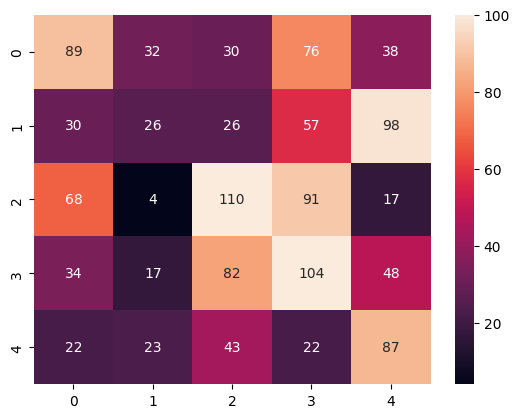

In [65]:
conf=confusion_matrix(np.argmax(y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)